# Lab 6

## Part A

In [28]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.inspection import DecisionBoundaryDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from scipy.stats import loguniform, uniform


1. Use sklearn.datasets.make moons(n samples=800, noise=0.1) to generate two interleaving
classes. Scatter-plot the data (colour by class).

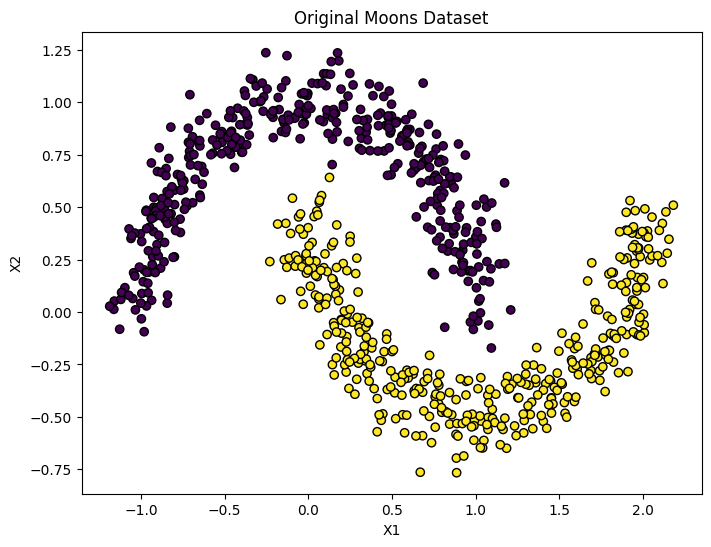

In [29]:
X, y = make_moons(n_samples=800, noise=0.1, random_state=42)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k')
plt.title('Original Moons Dataset')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

2. Randomly flip 10% of labels to inject mild label noise.

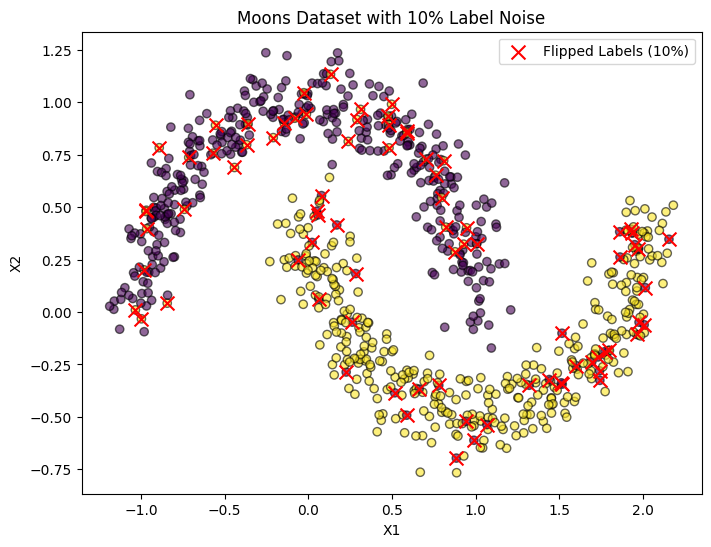

In [30]:
y_noisy = y.copy()
n_samples = len(y)
n_flips = int(n_samples * 0.10)

rs = np.random.RandomState(42) 
flip_i = rs.choice(n_samples, n_flips, replace=False)

y_noisy[flip_i] = 1 - y_noisy[flip_i]

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_noisy, cmap='viridis', edgecolors='k', alpha=0.6)
plt.scatter(X[flip_i, 0], X[flip_i, 1], c='r', marker='x', s=100, label='Flipped Labels (10%)')
plt.title('Moons Dataset with 10% Label Noise')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

3. Create a 70/30 stratified split and scale features with StandardScaler in a Pipeline

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, 
                                                      test_size=0.3, 
                                                      stratify=y_noisy, 
                                                      random_state=42)

base_mlp = MLPClassifier(random_state=42)
pipeline_ = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', base_mlp)
])

print("Create 70/30 stratified split:")
print(f"Xtrain shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"\nPipeline:\n{pipeline_}")

Create 70/30 stratified split:
Xtrain shape: (560, 2)
X_test shape: (240, 2)
y_train shape: (560,)
y_test shape: (240,)

Pipeline:
Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp', MLPClassifier(random_state=42))])


4. Classify the data using an MLPClassifier

In [32]:
seeds = [1, 100, 500, 2077, 77]
accs = []
aucs = []

for seed in seeds:
    X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X, y_noisy, 
                                                                    test_size=0.3, 
                                                                    stratify=y_noisy, 
                                                                    random_state=seed)
    
    mlp = MLPClassifier(max_iter=1000, 
                        solver='adam', 
                        early_stopping=True, 
                        validation_fraction=0.2, 
                        random_state=seed) 
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', mlp)S
    ])
    
    pipeline.fit(X_train_rs, y_train_rs)
    
    y_pred = pipeline.predict(X_test_rs)
    y_proba = pipeline.predict_proba(X_test_rs)[:, 1]
    
    acc = accuracy_score(y_test_rs, y_pred)
    auc = roc_auc_score(y_test_rs, y_proba)
    
    accs.append(acc)
    aucs.append(auc)
    
    print(f"Seed {seed}: Accuracy={acc:.3f}, AUC={auc:.3f}")

print(f"\nMean Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"Mean AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")

Seed 1: Accuracy=0.771, AUC=0.877
Seed 100: Accuracy=0.775, AUC=0.865
Seed 500: Accuracy=0.800, AUC=0.889
Seed 2077: Accuracy=0.825, AUC=0.887
Seed 77: Accuracy=0.796, AUC=0.852

Mean Accuracy: 0.793 ± 0.019
Mean AUC: 0.874 ± 0.014


5. Train grids of architectures and plot decision boundaries

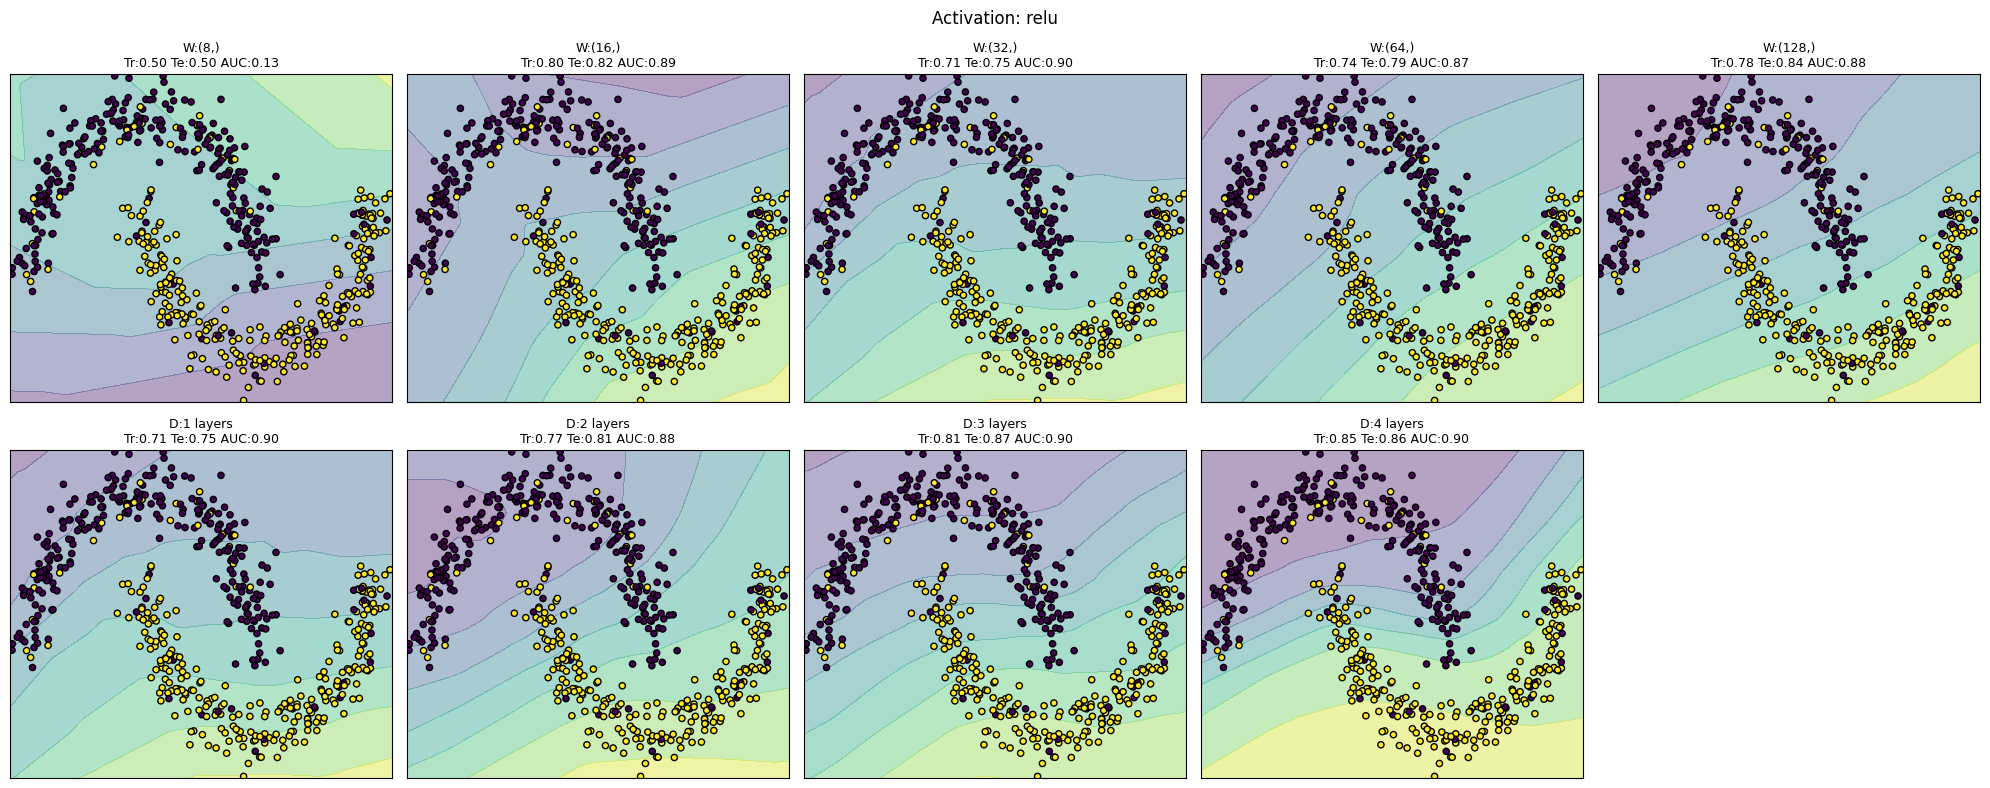

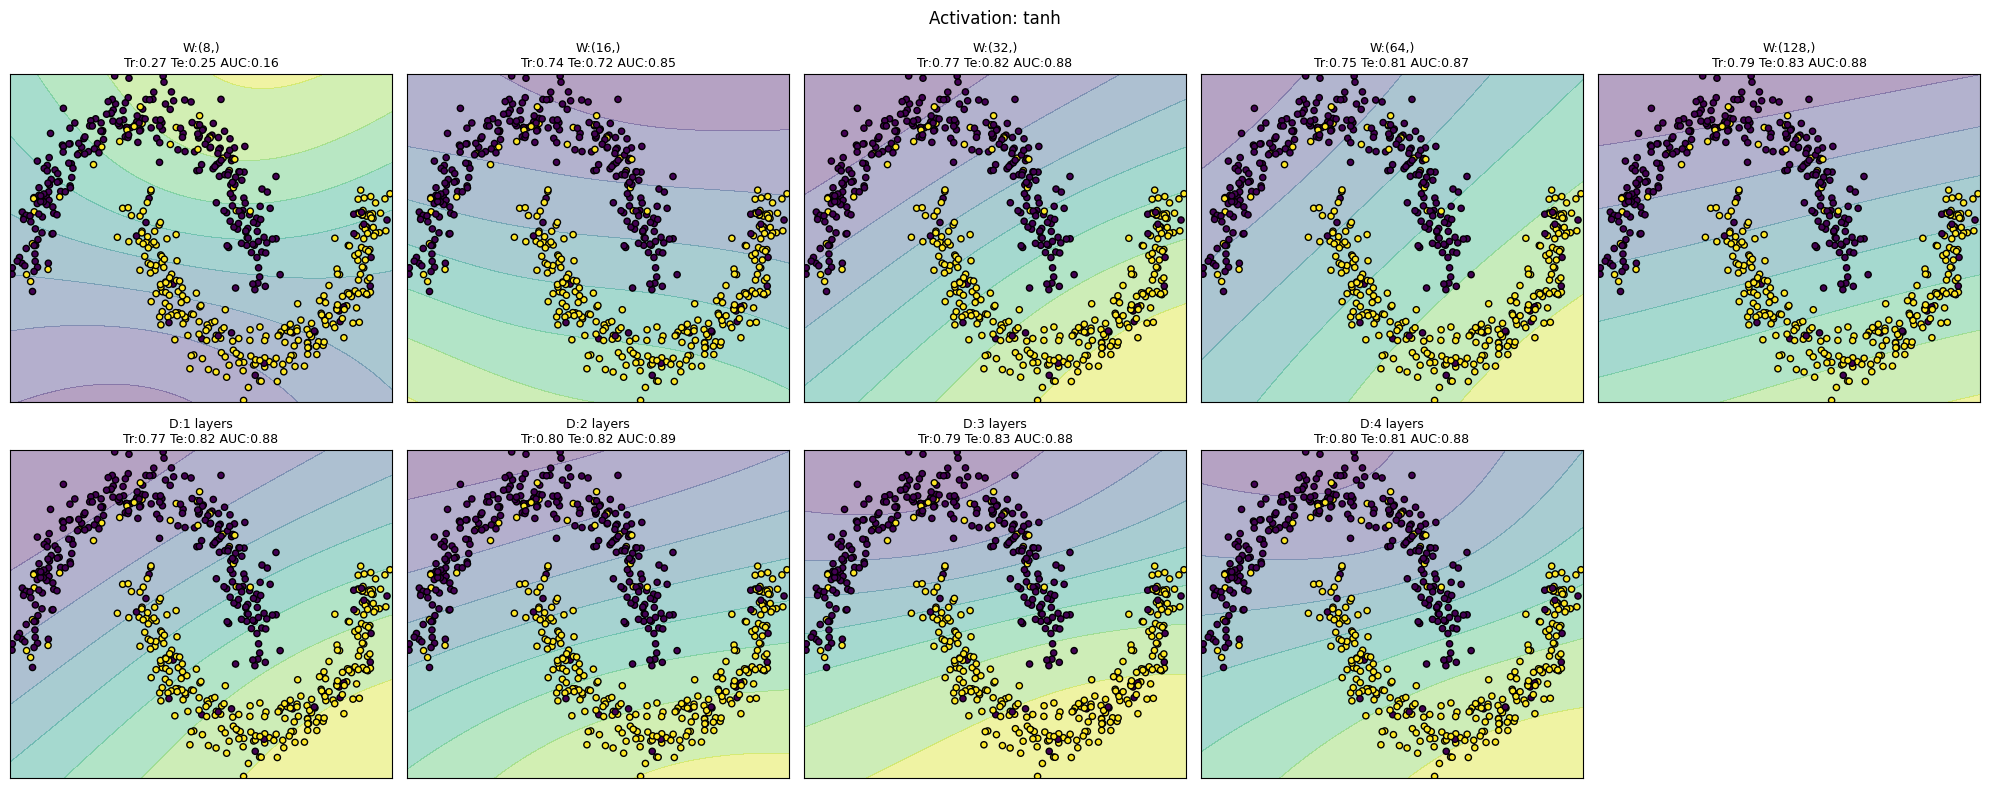

In [33]:

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

widths = [(8,), (16,), (32,), (64,), (128,)]
depths = [(32,), (32, 32), (32, 32, 32), (32, 32, 32, 32)]
acts = ['relu', 'tanh']

hp = {
    'max_iter': 1000,
    'solver': 'adam',
    'early_stopping': True,
    'validation_fraction': 0.2,
    'random_state': 42
}

for act in acts:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle(f'Activation: {act}')

    for i, w in enumerate(widths):
        clf = MLPClassifier(hidden_layer_sizes=w, activation=act, **hp)
        clf.fit(X_train_scaled, y_train)

        tr = clf.score(X_train_scaled, y_train)
        te = clf.score(X_test_scaled, y_test)
        auc = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])

        ax = axes[0, i]
        DecisionBoundaryDisplay.from_estimator(clf, X_train_scaled, ax=ax, cmap='viridis', alpha=0.4, eps=0.02)
        ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=20)
        ax.set_title(f"W:{w}\nTr:{tr:.2f} Te:{te:.2f} AUC:{auc:.2f}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    for i, d in enumerate(depths):
        clf = MLPClassifier(hidden_layer_sizes=d, activation=act, **hp)
        clf.fit(X_train_scaled, y_train)

        tr = clf.score(X_train_scaled, y_train)
        te = clf.score(X_test_scaled, y_test)
        auc = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])

        ax = axes[1, i]
        DecisionBoundaryDisplay.from_estimator(clf, X_train_scaled, ax=ax, cmap='viridis', alpha=0.4, eps=0.02)
        ax.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='viridis', edgecolors='k', s=20)
        ax.set_title(f"D:{len(d)} layers\nTr:{tr:.2f} Te:{te:.2f} AUC:{auc:.2f}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    axes[1, 4].axis('off')
    plt.tight_layout()
    plt.show()


$6. Increase label-noise rate to 20% and retrain with weight decay

In [43]:
X, y = make_moons(n_samples=800, noise=0.1, random_state=42)

y_mod = y.copy()
rng = np.random.RandomState(42)
n_flip = int(len(y) * 0.20)
idx = rng.choice(len(y), n_flip, replace=False)
y_mod[idx] = 1 - y_mod[idx]

X_tr, X_te, y_tr, y_te = train_test_split(X, y_mod, test_size=0.3, stratify=y_mod, random_state=42)

mlp_args = {
    'hidden_layer_sizes': (32, 32, 32, 32),
    'activation': 'relu',
    'solver': 'adam',
    'max_iter': 2000,
    'random_state': 42,
    'early_stopping': False
}

pipe_base = make_pipeline(StandardScaler(), MLPClassifier(alpha=0.0, **mlp_args))
pipe_base.fit(X_tr, y_tr)
preds_base = pipe_base.predict_proba(X_te)[:, 1]
auc_base = roc_auc_score(y_te, preds_base)

pipe_search = make_pipeline(StandardScaler(), MLPClassifier(**mlp_args))
param_grid = {'mlpclassifier__alpha': [1e-5, 1e-4, 1e-3]}

gs = GridSearchCV(pipe_search, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
gs.fit(X_tr, y_tr)

best_model = gs.best_estimator_
preds_reg = best_model.predict_proba(X_te)[:, 1]
auc_reg = roc_auc_score(y_te, preds_reg)

print(f"Baseline Test AUC (alpha=0.0): {auc_base:.4f}")
print(f"Best Validation AUC: {gs.best_score_:.4f}")
print(f"Best Alpha: {gs.best_params_['mlpclassifier__alpha']}")
print(f"Regularized Test AUC: {auc_reg:.4f}")
print(f"Change in Test AUC: {auc_reg - auc_base:+.4f}")

Baseline Test AUC (alpha=0.0): 0.7851
Best Validation AUC: 0.8159
Best Alpha: 0.0001
Regularized Test AUC: 0.7901
Change in Test AUC: +0.0049


## Part B

1. Setup.

In [35]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (14448, 8)
X_test shape: (6192, 8)


2. Baseline model.

In [46]:
baseline_m = MLPRegressor(hidden_layer_sizes=(128, 128),
                          activation='relu',
                          max_iter=1000,
                          random_state=42)

baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', baseline_m)
])

baseline_pipeline.fit(X_train, y_train)

y_pred = baseline_pipeline.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

RMSE: 0.5171
MAE:  0.3491
R2:   0.7963


3. Regularisation & early stopping.

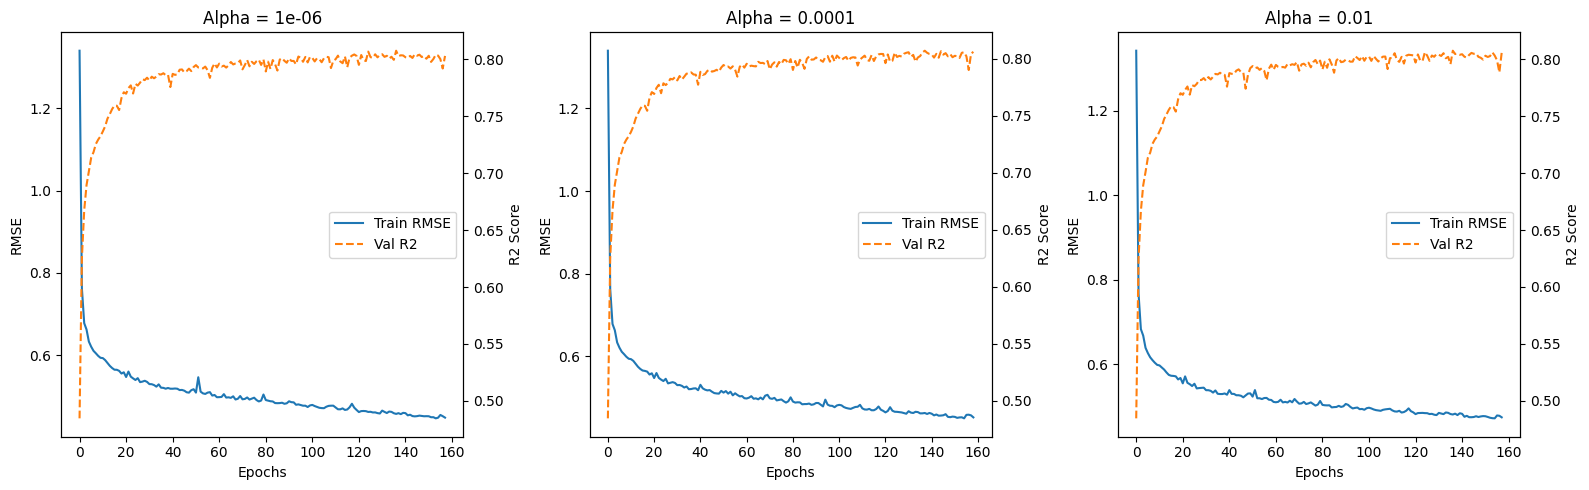

In [52]:

alphas = [1e-6, 1e-4, 1e-2]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, a in enumerate(alphas):
    mlp = MLPRegressor(
        hidden_layer_sizes=(128, 128),
        activation='relu',
        solver='adam',
        alpha=a,
        early_stopping=True,
        validation_fraction=0.2,
        n_iter_no_change=20,
        max_iter=300,
        random_state=42
    )

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('reg', mlp)
    ])

    model.fit(X_train, y_train)

    est = model.named_steps['reg']
    train_rmse = np.sqrt(2 * np.array(est.loss_curve_))
    val_r2 = est.validation_scores_

    ax1 = axes[i]
    l1 = ax1.plot(train_rmse, label='Train RMSE', color='tab:blue')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('RMSE')

    ax2 = ax1.twinx()
    l2 = ax2.plot(val_r2, label='Val R2', color='tab:orange', linestyle='--')
    ax2.set_ylabel('R2 Score')

    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='center right')
    ax1.set_title(f'Alpha = {a}')

plt.tight_layout()
plt.show()

4. Learning-rate schedule. 

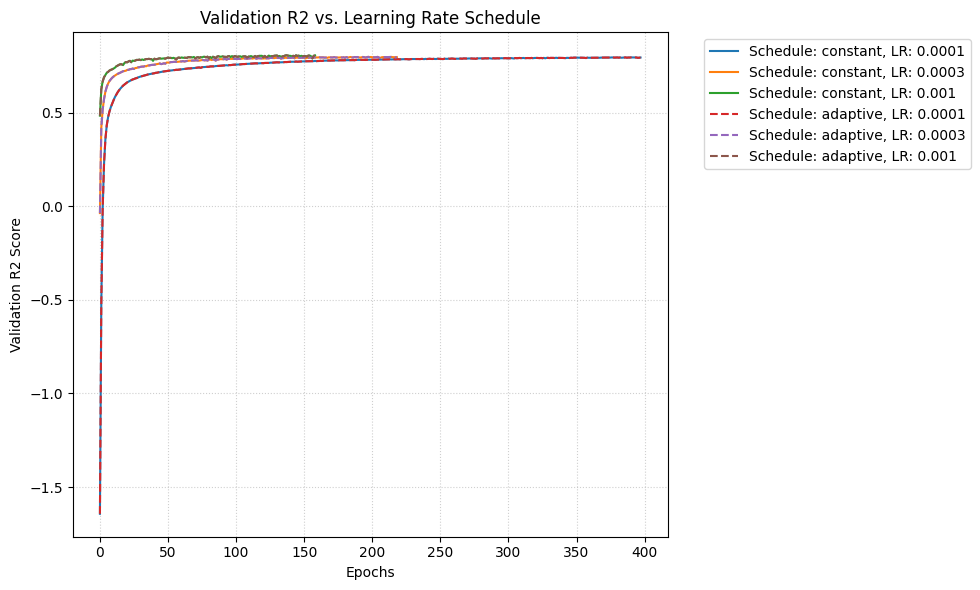

In [54]:
schedules = ['constant', 'adaptive']
learning_rates = [1e-4, 3e-4, 1e-3]


plt.figure(figsize=(10, 6))

for schedule in schedules:
    for lr_init in learning_rates:
        lr_mlp = MLPRegressor(hidden_layer_sizes=(128, 128),
                              activation='relu',
                              max_iter=1000,
                              random_state=42,
                              alpha=0.0001 ,
                              learning_rate=schedule,
                              learning_rate_init=lr_init,
                              early_stopping=True,
                              validation_fraction=0.2,
                              n_iter_no_change=20)
        
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('mlp', lr_mlp)
        ])
        
        pipeline.fit(X_train, y_train)
        
        valid_r2 = pipeline.named_steps['mlp'].validation_scores_
        label = f"Schedule: {schedule}, LR: {lr_init}"
        linestyle = '--' if schedule == 'adaptive' else '-'
        plt.plot(valid_r2, label=label, linestyle=linestyle)

plt.title('Validation R2 vs. Learning Rate Schedule')
plt.xlabel('Epochs')
plt.ylabel('Validation R2 Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

5. Hyperparameter optimisation (RandomizedSearchCV). 

In [56]:
search_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=1000, early_stopping=True, random_state=42))
])


param_grid_adam = {
    'mlp__solver': ['adam'],
    'mlp__hidden_layer_sizes': [(64, 64), (128, 128), (256, 256), (128, 64)],
    'mlp__alpha': loguniform(1e-6, 1e-2),
    'mlp__learning_rate_init': loguniform(1e-4, 1e-2),
    'mlp__batch_size': [32, 64, 128]
}

param_grid_sgd = {
    'mlp__solver': ['sgd'],
    'mlp__hidden_layer_sizes': [(64, 64), (128, 128), (256, 256), (128, 64)],
    'mlp__alpha': loguniform(1e-6, 1e-2),
    'mlp__learning_rate_init': loguniform(1e-4, 1e-2),
    'mlp__batch_size': [32, 64, 128],
    'mlp__momentum': uniform(0.6, 0.35)
}

n_iterations = 20 

random_search = RandomizedSearchCV(
    estimator=search_pipeline,
    param_distributions=[param_grid_adam, param_grid_sgd],
    n_iter=n_iterations,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1 
)

random_search.fit(X_train, y_train)

best_cv_rmse = -random_search.best_score_
print(f"Best Mean CV RMSE: {best_cv_rmse:.4f}")
print("Best Parameters:")
print(random_search.best_params_)



best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

best_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
best_mae = mean_absolute_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)

print(f"Test RMSE: {best_rmse:.4f}")
print(f"Test MAE:  {best_mae:.4f}")
print(f"Test R2:   {best_r2:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Mean CV RMSE: 0.5283
Best Parameters:
{'mlp__alpha': np.float64(0.0015352246941973493), 'mlp__batch_size': 128, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': np.float64(0.0036256176345762273), 'mlp__solver': 'adam'}
Test RMSE: 0.5104
Test MAE:  0.3389
Test R2:   0.8015
